In [1]:
%reload_ext autoreload
%autoreload 2
# %load_ext wurlitzer

import sys
sys.path.append("../")

import numpy as np
import time
from utils import model
from inference import log_marginal_likelihood as lmlpy
from utils import hyperparameters

import matplotlib.pyplot as plt
import utils.mpl_stylesheet as mplstyle
mplstyle.banskt_presentation()

In [2]:
nsample = 2000
nsnps = 100
hg2 = 0.8

x, y, v, sigma = model.simulate_allsnps(nsample, nsnps, hg2)

Creating phenotype with sigma 0.0883392, heritability 0.8, sigma_tau 0.447214
Using 100 causal SNPs


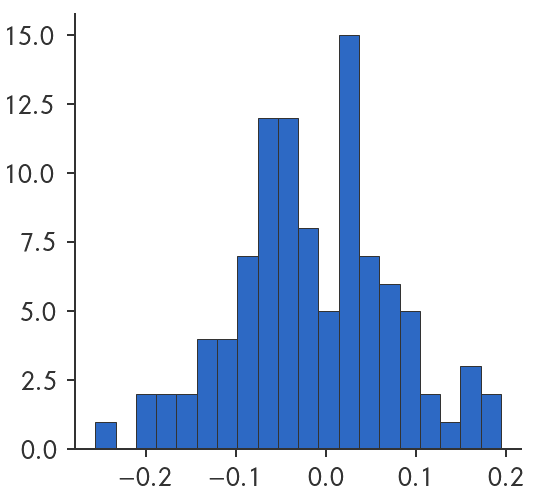

In [3]:
plt.figure()
plt.hist(v)
plt.show()

In [4]:
from sklearn import linear_model
lm = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lm.fit(x.T, y)
vest = lm.coef_
print (np.std(vest))

0.0882536629356


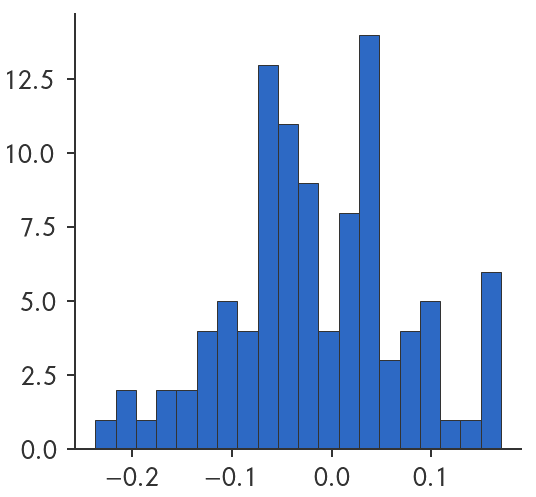

In [5]:
plt.figure()
plt.hist(vest)
plt.show()

In [6]:
def mylml(x, y, alpha, sigma):
    n = x.shape[1]
    A = np.dot(x.T, x) * sigma * sigma
    A[np.diag_indices_from(A)] += alpha * alpha
    logdetA = np.linalg.slogdet(A)[1]
    invA = np.linalg.inv(A)
    lml = - 0.5 * ( n * np.log(2 * np.pi) + logdetA + np.dot(y.T, np.dot(invA, y)) )
    return -lml

In [7]:
sigmavals = np.logspace(-3, 0, num = 20, base = 10)
alpha = np.sqrt(1 - hg2)
lml = np.zeros_like(sigmavals)

print("Testing sigma")
for i, msig in enumerate(sigmavals):
    print(".", end="")
    lml[i] = mylml(x, y, alpha, msig)
print(".")
    
actual_min = sigmavals[np.where(np.isin(lml, np.min(lml)))[0][0]]
print("Ground truth: {:g}".format(sigma))
print("Estimation from multiple linear regression: {:g}".format(np.std(vest)))
print("Estimation from marginal likelihood optim: {:g}".format(actual_min))

Testing sigma
.....................
Ground truth: 0.0883392
Estimation from multiple linear regression: 0.0882537
Estimation from marginal likelihood optim: 0.078476


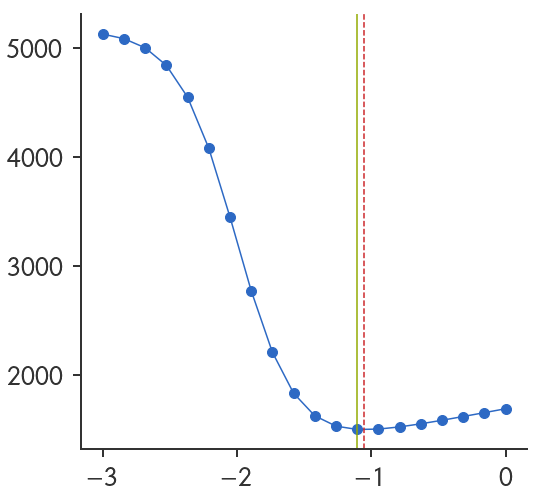

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.log10(sigmavals), lml, s = 100)
ax.plot(np.log10(sigmavals), lml)
ax.axvline(np.log10(sigma), linestyle="dashed", color = mplstyle.banskt_colors()[1])
ax.axvline(np.log10(actual_min), color = mplstyle.banskt_colors()[2])
plt.show()

# Include \pi

In [84]:
nsample = 2000
nsnps = 100
pi = 0.1
hg2 = 0.4
mu = 0.0
alpha = np.sqrt(1 - hg2)

x, y, csnps, v, sigma = model.simulate_base(nsample, nsnps, pi, hg2)

params = np.append(pi, [mu, sigma, 0.0, 1 / (alpha * alpha)])
zstates = [[]] + list([i] for i in csnps)

Creating phenotype with sigma 0.195528, heritability 0.4, sigma_tau 0.774597
Using 9 causal SNPs


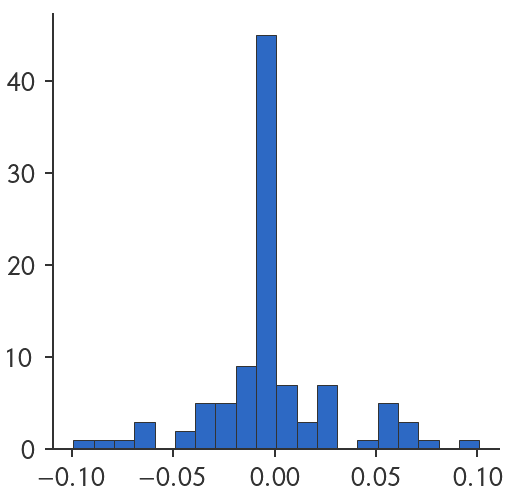

In [72]:
plt.figure()
plt.hist(v)
plt.show()

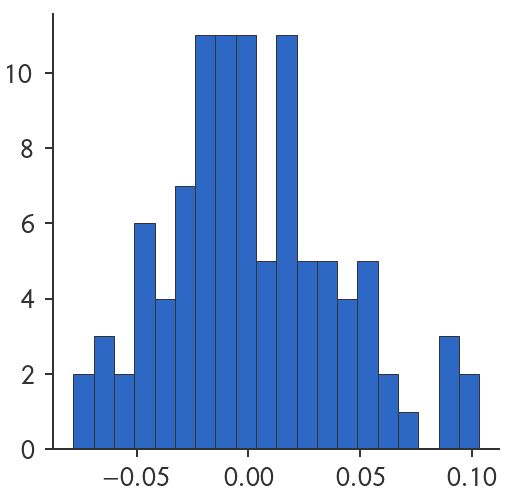

57 causal SNPs estimated with an overlap of 41 SNPs
Estimated standard deviation: 0.0502736


In [73]:
from sklearn import linear_model
lm = linear_model.LinearRegression(fit_intercept=True, normalize=False)
lm.fit(x.T, y)
vest = lm.coef_
plt.figure()
plt.hist(vest)
plt.show()

cest = np.where(np.abs(vest) > 0.02)[0]
print("{:d} causal SNPs estimated with an overlap of {:d} SNPs".format(cest.shape[0], len(set(csnps).intersection(set(cest)))))
print("Estimated standard deviation: {:g}".format(np.std(vest[cest])))

In [22]:
def mat3mul(A, B, C):
    return np.dot(A, np.dot(B, C))


def mylmlz_old(x, y, params, zstates):
    n = x.shape[1]
    nsnps = x.shape[0]
    _pi = params[0]
    _sigma = params[2]
    _alpha = np.sqrt(1 / params[4])
    _alpha2 = _alpha * _alpha
    
    loglmlz = np.zeros(len(zstates))
    Astored = np.dot(x, x.T)  / _alpha2
    logdet0 = n * np.log(_alpha * _alpha)
    
    for i, z in enumerate(zstates):
        nc = len(z)
        zarr = np.array(z)
        logpz = nc * np.log(_pi) + (nsnps - nc) * np.log(1 - _pi)
        invA = np.eye(n) / _alpha2
        if nc == 0:
            logdetA = logdet0
        elif nc == 1:
            Bzinv = np.zeros((nsnps, nsnps))
            Az = Astored[zarr, zarr] + _sigma * _sigma
            Bzinv[zarr, zarr] = 1 / Az
            invA = invA - (1 / _alpha2 / _alpha2) * mat3mul(x.T, Bzinv, x)
            xz = x[zarr[0], :]
            logdetA = logdet0 + np.log(1 + _sigma * _sigma * np.dot(xz.T, xz) / _alpha / _alpha)
        elif nc > 1:
            print ("Not implemented yet")
        nterm =  np.dot(y.T, np.dot(invA, y))
        logny = - 0.5 * ( n * np.log(2 * np.pi) + logdetA + nterm )
        loglmlz[i] = logpz + logny
        
    logk = np.max(loglmlz)
    marglik_k = np.sum(np.exp(loglmlz - logk))
    lml = logk + np.log(marglik_k)
    return -lml

def mylmlz(x, y, params, zstates):
    n = x.shape[1]
    nsnps = x.shape[0]
    _pi = params[0]
    _sigma = params[2]
    _alpha = params[4]
    _alpha2 = _alpha * _alpha
    _alpha4 = _alpha2 * _alpha2
    _sigma2 = _sigma * _sigma
    
    loglmlz = np.zeros(len(zstates))
    logdetS0 = n * np.log(_alpha * _alpha)
    S0inv = np.eye(n) / (_alpha * _alpha)
    
    for i, z in enumerate(zstates):
        nc = len(z)
        zarr = np.array(z)
        logpz = nc * np.log(_pi) + (nsnps - nc) * np.log(1 - _pi)
        
        Szinv = S0inv.copy()
        logdetS = logdetS0
        
        if nc == 1:
            zpos = z[0]
            xz = x[zpos, :]
            logdetS += np.log(1 + _sigma * _sigma * np.dot(xz.T, xz) / _alpha / _alpha)
            Szconst = _sigma2 / _alpha2 / (_alpha2 + _sigma2 * np.dot(xz, xz))
            Szinv -= np.outer(xz, xz.T) * Szconst

        logny = - 0.5 * ( n * np.log(2 * np.pi) + logdetS + mat3mul(y.T, Szinv, y) )        
        loglmlz[i] = logpz + logny

    logk = np.max(loglmlz)
    marglik_k = np.sum(np.exp(loglmlz - logk))
    lml = logk + np.log(marglik_k)
    return -lml


def mylmlzfull(x, y, params, zstates):
    n = x.shape[1]
    nsnps = x.shape[0]
    _pi = params[0]
    _sigma = params[2]
    _alpha = params[4]
    
    loglmlz = np.zeros(len(zstates))
    for i, z in enumerate(zstates):
        nc = len(z)
        zarr = np.array(z)
        logpz = nc * np.log(_pi) + (nsnps - nc) * np.log(1 - _pi)
        
        Bz = np.zeros((nsnps, nsnps))
        if nc == 1:
            zpos = z[0]
            Bz[zpos, zpos] = _sigma * _sigma
        Sz = mat3mul(x.T, Bz, x)
        Sz[np.diag_indices_from(Sz)] += _alpha * _alpha
        logdetS = np.linalg.slogdet(Sz)[1]
        Szinv = np.linalg.inv(Sz)
        
        logny = - 0.5 * ( n * np.log(2 * np.pi) + logdetS + mat3mul(y.T, Szinv, y) )
        #print ("full", z, logny)
        
        loglmlz[i] = logpz + logny
        
    logk = np.max(loglmlz)
    marglik_k = np.sum(np.exp(loglmlz - logk))
    lml = logk + np.log(marglik_k)
    return -lml

In [ ]:
sigmavals = np.logspace(-3, 0, num = 20, base = 10)
lml1 = np.zeros_like(sigmavals)

print("Testing sigma")
for i, msig in enumerate(sigmavals):
    _params = params.copy()
    _params[2] = msig
    lml1[i] = mylmlzfull(x, y, _params, zstates)
    print("{:g} {:g}".format(msig, lml1[i]))
    
actual_min = sigmavals[np.where(np.isin(lml1, np.min(lml1)))[0][0]]
print("Ground truth: {:g}".format(sigma))
print("Observerd min: {:g}".format(actual_min))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.log10(sigmavals), lml1, s = 100)
ax.plot(np.log10(sigmavals), lml1)
ax.axvline(np.log10(sigma), linestyle="dashed", color = mplstyle.banskt_colors()[1])
ax.axvline(np.log10(actual_min), color = mplstyle.banskt_colors()[2])
plt.show()

Testing sigma
 0.010 3239.95
 0.012 3238.76
 0.014 3236.94
 0.017 3234.42
 0.020 3231.18
 0.024 3227.26
 0.029 3222.73
 0.035 3217.8
 0.041 3212.75
 0.049 3207.89
 0.059 3203.5
 0.070 3199.74
 0.084 3196.7
 0.100 3194.32
 0.119 3192.55
 0.143 3191.27
 0.170 3190.37
 0.203 3189.77
 0.242 3189.39
 0.289 3189.17
 0.346 3189.07
 0.412 3189.04
 0.492 3189.08
 0.588 3189.16
 0.702 3189.26
 0.838 3189.39
 1.000 3189.53
 1.194 3189.69
 1.425 3189.85
 1.701 3190.01
 2.031 3190.18
 2.424 3190.35
 2.894 3190.52
 3.455 3190.7
 4.125 3190.87
 4.924 3191.05
 5.878 3191.23
 7.017 3191.4
 8.377 3191.58
10.000 3191.76
Ground truth: 0.236993
Observerd min: 0.412463


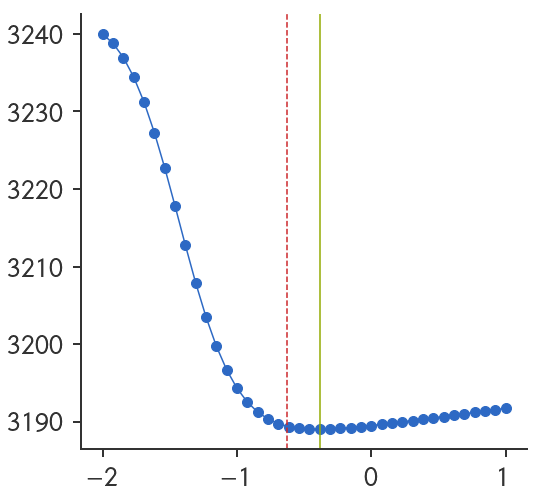

In [83]:
print("Testing sigma")
sigmavals = np.logspace(-2, 1, num = 40, base = 10)
lml2 = np.zeros_like(sigmavals)
for i, msig in enumerate(sigmavals):
    _params = params.copy()
    _params[2] = msig
    lml2[i] = mylmlzpart(x, y, _params, zstates)
    print("{:6.3f} {:g}".format(msig, lml2[i]))
    
    
actual_min = sigmavals[np.where(np.isin(lml2, np.min(lml2)))[0][0]]
print("Ground truth: {:g}".format(sigma))
print("Observerd min: {:g}".format(actual_min))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.log10(sigmavals), lml2, s = 100)
ax.plot(np.log10(sigmavals), lml2)
ax.axvline(np.log10(sigma), linestyle="dashed", color = mplstyle.banskt_colors()[1])
ax.axvline(np.log10(actual_min), color = mplstyle.banskt_colors()[2])
plt.show()